# IMPORTS

In [24]:
import pandas as pd
import numpy as np
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, MSTL
from statsforecast.arima import arima_string
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import scipy.stats as stats
from pylab import rcParams



# PLOT STYLE (FROM NIXTLA SITE)

In [25]:
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

rcParams['figure.figsize'] = (18,7)

# READING DATAFRAMES AND MERGING THEM 

In [26]:
df1 = pd.read_csv('C:/Users/ARuposh/Downloads/neww.csv')
df2 = pd.read_csv('C:/Users/ARuposh/Downloads/TOTAL_SALES_PER_FISCAL_YEAR_MUSIC.csv')

# Merging and sorting the values 
df = df1.merge(df2, on='YEAR_ID', how='left')
df['DATE_ID'] = pd.to_datetime(df['DATE_ID'])
df = df.sort_values('DATE_ID')
df['TOTAL_WEEK_SALES'] = df['TOTAL_WEEK_SALES'].astype(float)

# CALCULATING THE BUSINESS INDEX 

In [27]:
# Calculating Businesss Index and handling division by zero
df['BI'] = np.where(df['TOTAL_WEEK_SALES'] == 0, 0, df['TOTAL_YEAR_SALES'] / df['TOTAL_WEEK_SALES'])

# CREATING THE CUTOFF FOR TRAIN DF

In [28]:
cutoff = '2025-05-04'


# CALCULATING THE ROLLING AVERAGE FOR THE DATAFRAME WITH THE CUTOFF

In [29]:
# Cutoff version RA
df['RA_cutoff'] = df['TOTAL_WEEK_SALES'].rolling(window=52, min_periods=1).mean().where(df['DATE_ID'] <= cutoff)
cutoff_ra_value = df.loc[df['DATE_ID'] == cutoff, 'RA_cutoff'].iloc[0]
df.loc[df['DATE_ID'] > cutoff, 'RA_cutoff'] = cutoff_ra_value

# CALCULATING THE ROLLING AVERAGE FOR THE DATAFRAME WITHOUT THE CUTOFF

In [30]:
df['RA_no_cutoff'] = df['TOTAL_WEEK_SALES'].rolling(window=52, min_periods=1).mean()


# CALCULATING THE ROLLING AVERAGE x BUSINESS INDEX

In [31]:
# Calculate both versions of RA × BI
df['RA_X_BI_cutoff'] = df['BI'] * df['RA_cutoff']
df['RA_X_BI_no_cutoff'] = df['BI'] * df['RA_no_cutoff']

# CREATING THE TRAIN AND TEST DATAFRAMES

In [32]:
train_df = df[df['DATE_ID'] <= cutoff]
test_df = df[df['DATE_ID'] > cutoff]

# CREATING THE TRAIN FORECAST

In [33]:
train_fcst = train_df[['DATE_ID', 'TOTAL_WEEK_SALES']].copy()
train_fcst = train_fcst.rename(columns={'DATE_ID': 'ds', 'TOTAL_WEEK_SALES': 'y'})
train_fcst['unique_id'] = 'MUSIC'

# VISUALS FOR AUTOCORRELATIONS BETWEEN THE WEEKS

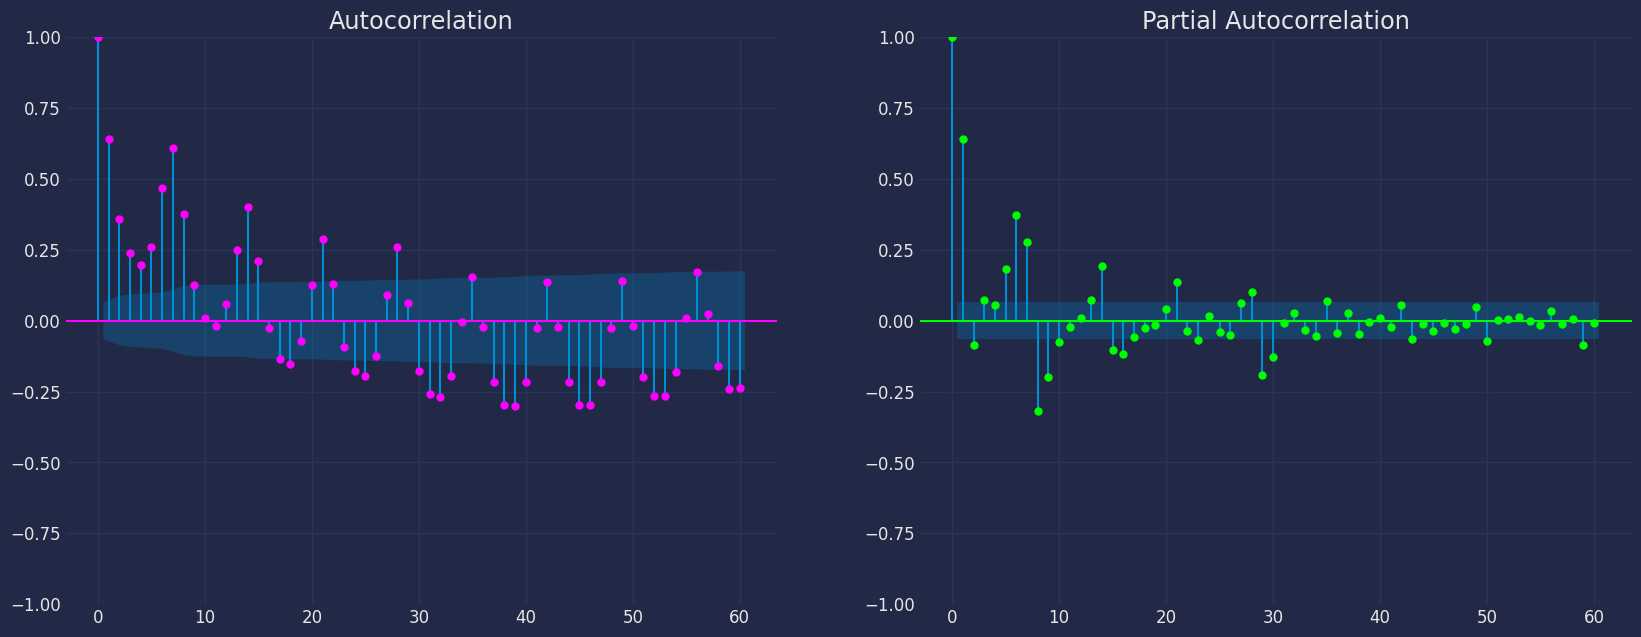

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(train_fcst["y"],  lags=60, ax=axs[0],color="fuchsia") #showing direct correlation between values and different lags
axs[0].set_title("Autocorrelation")

plot_pacf(train_fcst["y"],  lags=60, ax=axs[1],color="lime") #showing direct correlation after removing the effects of shorter lags
axs[1].set_title('Partial Autocorrelation')

plt.show()

# TEST DATAFRAME

In [35]:
test_df = test_df[['DATE_ID', 'TOTAL_WEEK_SALES', 'RA_X_BI_cutoff', 'RA_X_BI_no_cutoff']].copy()
test_df = test_df.rename(columns={'DATE_ID': 'ds', 'TOTAL_WEEK_SALES': 'y'})
test_df['unique_id'] = 'MUSIC'

# PLOTTING TRAINING AND TEST DATA

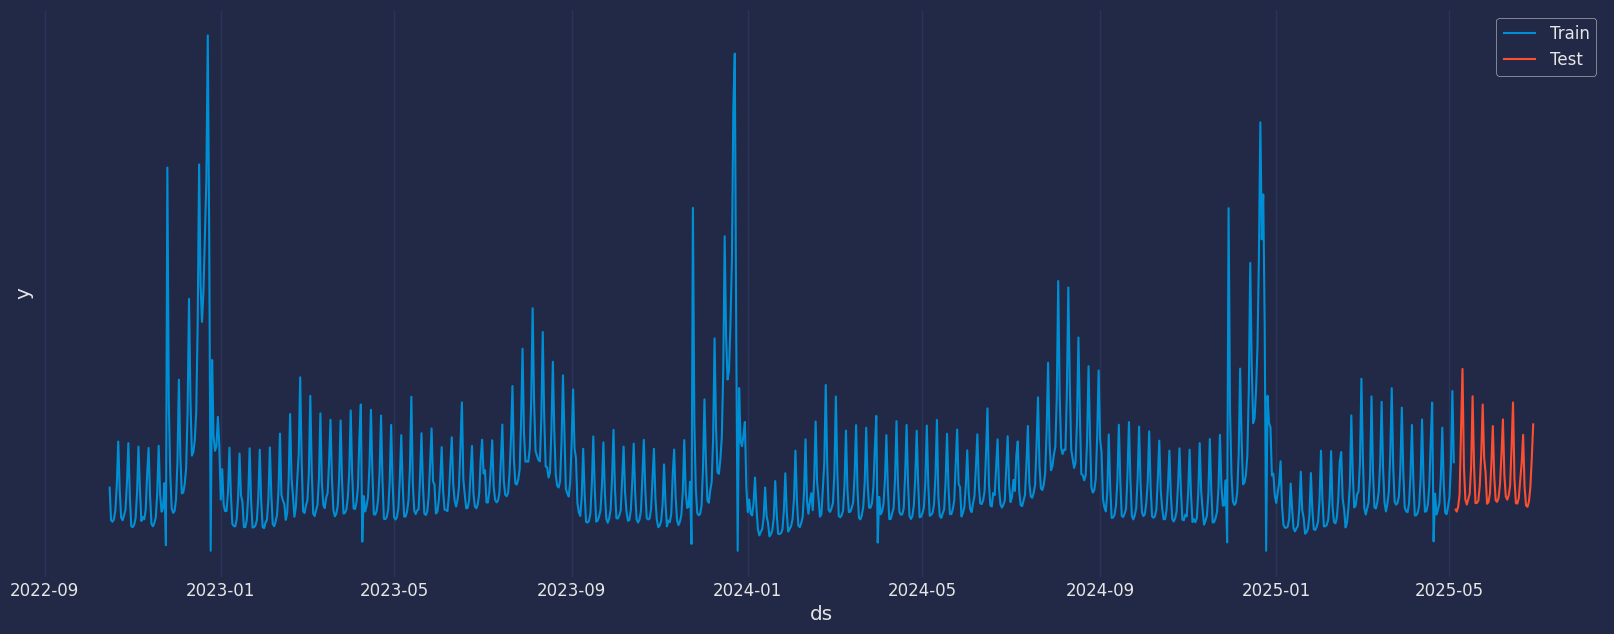

In [36]:
sns.lineplot(train_fcst,x="ds", y="y", label="Train")
sns.lineplot(test_df, x="ds", y="y", label="Test")
plt.yticks([])

plt.show()


# INSTANTIATING THE SEASON LENGTH AND HORIZON FORECAST

In [37]:
season_length = 52 # Weekly data 
horizon = len(test_df) # number of predictions (fcst horizon)

# INSTANTIATING THE MODEL 

In [38]:
models = [AutoARIMA(season_length=season_length, stepwise = True, approximation = True)]                 

sf = StatsForecast(
    models=models,
    freq='W',
    n_jobs=-1
)

# FITTING THE TRAIN DATA

In [39]:
sf.fit(df=train_fcst)


c:\Users\ARuposh\Projects\license_forecasting_data\.venv\Lib\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\ARuposh\Projects\license_forecasting_data\.venv\Lib\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\ARuposh\Projects\license_forecasting_data\.venv\Lib\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\ARuposh\Projects\license_forecasting_data\.venv\Lib\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\ARuposh\Projects\license_forecasting_data\.venv\Lib\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\ARuposh\Projects\license_forecasting_data\.venv\Lib\site-packages\

StatsForecast(models=[AutoARIMA])

# SEEING WHAT THE PARAMTERS OF THE MODEL ARE

In [40]:
model_params = arima_string(sf.fitted_[0,0].model_)
print(model_params)

ARIMA(2,0,4)(2,0,1)[52] with non-zero mean


# UNDERSTANDING THE VALUES

In [41]:
result=sf.fitted_[0,0].model_
print(result.keys())
print(result['arma'])

dict_keys(['coef', 'sigma2', 'var_coef', 'mask', 'loglik', 'aic', 'arma', 'residuals', 'code', 'n_cond', 'nobs', 'model', 'bic', 'aicc', 'ic', 'xreg', 'x', 'lambda'])
(2, 4, 2, 1, 52, 0, 0)


# CALCULATING THE RESIDUALS

In [42]:
residual = pd.DataFrame(result.get("residuals"), columns=["Residual Model"])

# DENSITY PLOY, RESIDUALS, AND Q-Q PLOT

C:\Users\ARuposh\AppData\Local\Temp\ipykernel_14852\348853009.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residual, ax=axs[0,1])


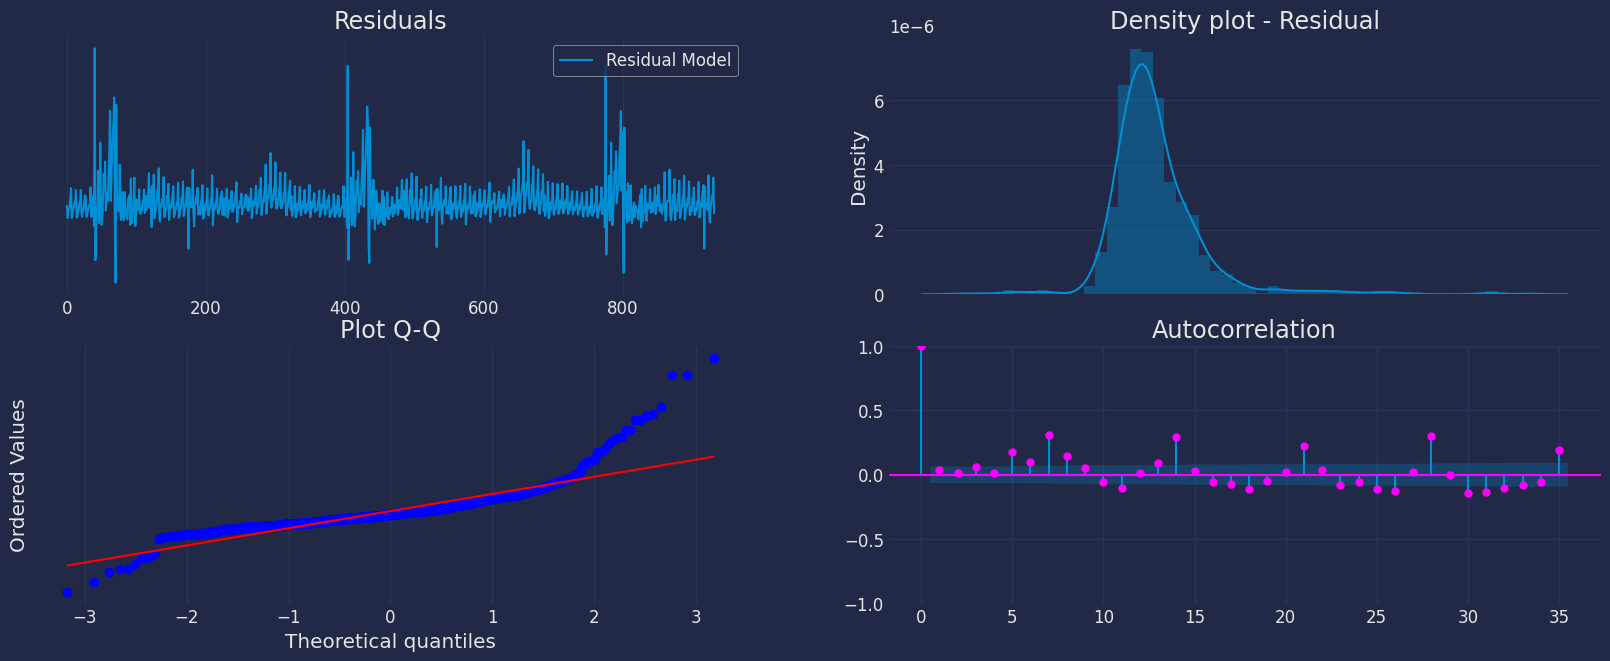

In [48]:
fig, axs = plt.subplots(nrows=2, ncols=2)

residual.plot(ax=axs[0,0])
axs[0,0].set_title("Residuals")
axs[0,0].set_yticks([]) 

sns.distplot(residual, ax=axs[0,1])
axs[0,1].set_title("Density plot - Residual")
axs[0,1].set_xticks([]) 

stats.probplot(residual["Residual Model"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')
axs[1,0].set_yticks([]) 

plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia")
axs[1,1].set_title("Autocorrelation")
plt.show()

# PREDICTION DATAFRAME

In [44]:
pred = sf.forecast(df = train_fcst, h = horizon, fitted = True)

c:\Users\ARuposh\Projects\license_forecasting_data\.venv\Lib\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\ARuposh\Projects\license_forecasting_data\.venv\Lib\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\ARuposh\Projects\license_forecasting_data\.venv\Lib\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\ARuposh\Projects\license_forecasting_data\.venv\Lib\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\ARuposh\Projects\license_forecasting_data\.venv\Lib\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\ARuposh\Projects\license_forecasting_data\.venv\Lib\site-packages\

# COMPARING ACTUALS VS PREDICTIONS

In [45]:
actuals = sf.forecast_fitted_values()

# CROSS VALIDATION

In [46]:
crossvalidation_df = sf.cross_validation(df = train_fcst, h = 52, step_size=1, n_windows=5)

c:\Users\ARuposh\Projects\license_forecasting_data\.venv\Lib\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\ARuposh\Projects\license_forecasting_data\.venv\Lib\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\ARuposh\Projects\license_forecasting_data\.venv\Lib\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\ARuposh\Projects\license_forecasting_data\.venv\Lib\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\ARuposh\Projects\license_forecasting_data\.venv\Lib\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\ARuposh\Projects\license_forecasting_data\.venv\Lib\site-packages\

# CALCULATING MAPE 

In [ ]:
mape = mean_absolute_percentage_error(crossvalidation_df['y'], crossvalidation_df['AutoARIMA'])

print(f'MAPE: {mape}')